## 빅데이터 실습

### 스타벅스매장 입지 분석

#### 데이터 수집

##### 데이터 전처리 마무리 하기


In [2]:
# 라이브러리 등록
from selenium import webdriver
import time
from bs4 import BeautifulSoup
from urllib import parse
from tqdm import tqdm
import pandas as pd

In [5]:
# 웹드라이버로 크롬 오픈
url = r"https://search.danawa.com/dsearch.php?k1=%EC%97%90%EC%96%B4%EB%A9%94%EC%9D%B4%EB%93%9C+%EC%8A%A4%EB%A7%88%ED%8A%B8%ED%83%80%EC%9B%8C&module=goods&act=dispMain"
driver = webdriver.Chrome()
driver.get(url)
time.sleep(5)

In [7]:
html = driver.page_source
soup = BeautifulSoup(html,'html.parser')

In [9]:
prodItems = soup.select('ul.product_list > li.prod_item')

In [18]:
prodItems[0].select('p.prod_name > a')[0].text.strip()

'에어메이드 스마트타워 AMC-3501A'

In [20]:
prodItems[0].select('div.spec_list')[0].text.strip().replace('\t','')

'핸디스틱청소기 / 무선 / 흡입형 / 흡입력: 370W / 2024년형 / [구성] 먼지비움 / 충전 / UVC LED / 브러쉬: 바닥 / 침구 / 솔형 / 틈새 / 먼지봉투: 2.5L / [배터리] 사용시간: 40분(최대) / 충전시간: 5시간 / 분리형(1개) / 2500mAh / [청소] LED라이트 / BLDC모터 / [부가] 디스플레이표시 / 헤파필터 / 색상: 화이트 / 무게: 2.5kg / 크기(가로x세로x깊이): 252x1253x185mm'

In [33]:
# 만약에 수가 아닌 문자열이 들어왔을 때는 False 이므로 추가 하지 않으면 된다.
prodItems[0].select('input')[4].get('value').isnumeric()

False

##### 다나와 무선 청소기 웹크롤링 다시
- 가격 외에는 들어오지 않도록

In [2]:
## 검색어랑 ,URL 페이지를 변경하면서 url 생성해주는 함수

def get_search_page_url(keyword,page):
    keyword = parse.quote(keyword)
    url = f'https://search.danawa.com/dsearch.php?query={keyword}&originalQuery={keyword}&previousKeyword={keyword}&checkedInfo=N&volumeType=allvs&page={page}&' + \
        'limit=120&sort=saveDESC&list=list&boost=true&tab=goods&addDelivery=N&coupangMemberSort=N&mode=simple&isInitTireSmartFinder=N&' +\
    'recommendedSort=N&defaultUICategoryCode=10325109&defaultPhysicsCategoryCode=72%7C80%7C81%7C0&defaultVmTab=3138&defaultVaTab=1098867&isZeroPrice=Y&'+\
        'quickProductYN=N&priceUnitSort=N&priceUnitSortOrder=A'
    return url


In [3]:
## 상품 정보 추출 함수
def getProdItems(prodItems):
    prodData = []

    for product in prodItems:
        try:
            product_name = product.select('p.prod_name >a')[0].text.strip()
            product_spec = product.select('div.spec_list')[0].text.strip().replace('\t','')
            if product.select('input')[1].get('value').isdecimal() == True:
                product_price = product.select('input')[1].get('value')
            else:
                product_price = 0 # 문자열 들어온 것을 막음
            product_reg_mon = product.select('div.prod_sub_meta> dl>dd')[0].text.strip()
            prodData.append([product_name,product_spec,product_price,product_reg_mon])
        except:
            pass
    return prodData

In [53]:
## 여러 페이지 검색후 크롤링하는 작업

driver = webdriver.Chrome()

# 암묵적으로 맵 자원 로드를 위해서 3초 정도 대기한다.
driver.implicitly_wait(3)

keyword = '무선청소기'
startPage = 1
totalPage = 20
# 최종 저장 리스트
prodDataTotal = []

for page in tqdm(range(startPage,totalPage+1)):
    url = get_search_page_url(keyword,page)
    driver.get(url)
    #페이지 로딩이 완료될 때 까지 5초 대기
    time.sleep(5)
    
    # 현재 페이지 url 가져오기
    html = driver.page_source
    soup = BeautifulSoup(html,'html.parser')

    # 상품 정보 추출
    prodItems = soup.select('ul.product_list > li.prod_item')
    prodItemList = getProdItems(prodItems)

    prodDataTotal += prodItemList

100%|██████████| 20/20 [04:17<00:00, 12.85s/it]


In [54]:
dfProDataTotal = pd.DataFrame(prodDataTotal)

In [58]:
dfProDataTotal.columns = ['제품명','제품스펙','최저가','등록월']

In [59]:
dfProDataTotal.to_excel('./data/다나와_무선청소기_결과.xlsx',index=False)

##### 크롤링 데이터 전처리

In [8]:
dfProdDanawa = pd.read_excel('./data/다나와_무선청소기_결과_최종.xlsx')

In [7]:
# 결측치 검색
condition = dfProdDanawa['제품스펙'].isnull()

dfProdDanawa[condition]

,제품명,제품스펙,최저가,등록월


In [27]:
# 결측치를 가진 행을 삭제
dfProdDanawa.dropna(axis=0,inplace=True)

In [30]:
dfProdDanawa.tail()

,제품명,제품스펙,최저가,등록월
2114,미니센 무선 소형 청소기 MNC-100 노즐 세트,차량용청소기 / 전용브러쉬,7000,2024.03.
2115,미니센 무선 소형 청소기 MNC-100 먼지통,차량용청소기 / 먼지통,7000,2024.03.
2116,프리라벨 2in1 무선 진공 청소기 LS-2000 헤파필터,차량용청소기 / 필터 / [필터] 헤파필터,3500,2024.03.
2118,포쉬 워시젯 V2 WJ200,침구청소기 / 핸디형 / 무선 / 사용시간: 25분(최대) / [기능] 청소모드: ...,219000,2024.02.
2119,업킵 MJ-BC779,침구청소기 / 핸디형 / 무선 / [기능] 청소모드: UV살균 / 속도조절 / 헤파...,89900,2024.02.


In [9]:
condition = dfProdDanawa['최저가'] == 0
dfProdDanawa[condition].info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제품명     0 non-null      object
 1   제품스펙    0 non-null      object
 2   최저가     0 non-null      int64 
 3   등록월     0 non-null      object
dtypes: int64(1), object(3)
memory usage: 0.0+ bytes


In [33]:
#최저가가 0이 아닌 행들만 다시 저장
dfProdDanawa = dfProdDanawa[condition != True]

In [38]:
# 결측치와 이상치를 제거하면 인덱스가 꼬이므로 인덱스를 다시 쵝화
dfProdDanawa.reset_index(drop=True,inplace=True)


In [10]:
# 결측치, 이상치를 제거하고 인덱스를 리셋시킨 최종 DataFrame
dfProdDanawa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057 entries, 0 to 2056
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제품명     2057 non-null   object
 1   제품스펙    2057 non-null   object
 2   최저가     2057 non-null   int64 
 3   등록월     2057 non-null   object
dtypes: int64(1), object(3)
memory usage: 64.4+ KB


In [49]:
# 회사명, 모델명을 분리 split(' ',n) n은 자를 기준의 순번
dfProdDanawa['제품명'][0].split(' ',1)

['LG전자', '오브제컬렉션 코드제로 A9S AX9884']

In [59]:
comList = []
modelList = []

for temp in dfProdDanawa['제품명']:
    titles = temp.split(' ',1)
    if(len(titles))> 1:
        comList.append(titles[0]) #회사명
        modelList.append(titles[1]) #모델명
    else:
        comList.append('') # 회사명이 없음
        modelList.append(titles[0]) # 모델명

In [59]:
comList.index('다기능')

997

In [97]:
specList = dfProdDanawa.loc[1,'제품스펙'].split(' / ')

In [100]:
specList

'핸디스틱청소기'

In [106]:
useTime = ''
sunctionPow = ''
for spec in specList:
    if '사용시간' in spec:
        useTime = spec
    elif '흡입력' in spec:
        sunctionPow = spec

print(useTime.split(":")[1].strip())
print(sunctionPow.split(":")[1].strip())

1시간(최대)
220W


In [11]:
## 위의 테스트를 기반으로 카테고리, 사용시간, 흡입력 추출
categoryList = []
useTimeList = []
sunctionPowList = []

for spec in dfProdDanawa['제품스펙']:
    specList = spec.split(' / ')

    #카테고리
    category = specList[0]
    categoryList.append(category)

    # 사용시간과 흡입력 추출
    useTimeVal = None
    sunctionPowVal = None

    for temp in specList:
        if '사용시간' in temp:
            useTimeVal = temp.replace('[배터리] ','') #'[배터리] '없애기
        elif '흡입력' in temp:
            sunctionPowVal = temp

    # 끝난 다음에도 사용시간, 흡입력이 None이면 스펙에 찾을 값이 없었음.
    if useTimeVal != None:
        useTIme = useTimeVal.split(" ")[1].strip().replace('(최대)','') # (최대) 삭제
    else:
        useTIme = ''

    if sunctionPowVal != None:
        sunctionPow = sunctionPowVal.split(" ")[1].strip()
    else:
        sunctionPow = ''
    
    useTimeList.append(useTIme)
    sunctionPowList.append(sunctionPow)

In [55]:
len(useTimeList)

2057

In [37]:
## 사용시간 단위 통일
# time = '1시간', '30분', '1시간 20분'
def convertHourToMin(time):
    try:
        if '시간' in time:
            hour = time.split('시간')[0]
            minute= 0
            if '분' in time:
                minute = time.split('시간')[-1].split('분')[0]
        elif '분' in time:
            hour = 0
            minute = time.split('분')[0]
        return int(hour) * 60 + int(minute)
    except:
        return None

In [39]:
newUseTimeList = []
for time in useTimeList:
    value = convertHourToMin(time)
    newUseTimeList.append(value)

In [54]:
len(newUseTimeList)

2057

In [50]:
##  흡입력 단위 1W = 1AW = 100pa
def converPow(value):
    try:
        value = value.upper()
        if 'AW' in value or 'W' in value:
            result = value.replace('A','').replace('W','').replace(',','') # A와 W삭제 쉼표 삭제
            result = int(result)
        elif 'PA' in value:
            result = value.replace('PA','').replace(',','') # PA 삭제 쉼표 삭제
            result = int(result) // 100
        else:
            result = None
        return result
    except:
        return None


In [56]:
newSuctionList =  []

for power in sunctionPowList:
    value = converPow(power)
    newSuctionList.append(value)

In [57]:
len(newSuctionList)

2057

In [60]:
# 최종 데이터 엑셀 저장
dfLast = pd.DataFrame()
dfLast['카테고리'] = categoryList
dfLast['회사명'] = comList
dfLast['모델명'] = modelList
dfLast['가격'] = dfProdDanawa['최저가']
dfLast['사용시간'] = newUseTimeList
dfLast['흡입력'] = newSuctionList

In [61]:
dfLast.tail()

,카테고리,회사명,모델명,가격,사용시간,흡입력
2052,차량용청소기,미니센,무선 소형 청소기 MNC-100 노즐 세트,7000,NaN,NaN
2053,차량용청소기,미니센,무선 소형 청소기 MNC-100 먼지통,7000,NaN,NaN
2054,차량용청소기,프리라벨,2in1 무선 진공 청소기 LS-2000 헤파필터,3500,NaN,NaN
2055,침구청소기,포쉬,워시젯 V2 WJ200,219000,25.0,NaN
2056,침구청소기,업킵,MJ-BC779,89900,NaN,NaN


In [ ]:
dfLast.to_excel('./data/다나와_무선청소기_전처리결과.xlsx',index=False)

In [2]:
dfCleaner = pd.read_excel('./data/다나와_무선청소기_전처리결과.xlsx')

##### 결측치와 이상치 수정

In [3]:
dfCleaner.isnull().sum()

카테고리       0
회사명        0
모델명        0
가격         0
사용시간     401
흡입력     1005
dtype: int64

In [4]:
condition = dfCleaner['회사명'].isnull()

dfCleaner[condition]

,카테고리,회사명,모델명,가격,사용시간,흡입력


In [5]:
## 사용 시간, 흡입력 NaN인 것은 전부 0으로 채워넣기
dfCleaner = dfCleaner.fillna(0)

In [6]:
dfCleaner.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057 entries, 0 to 2056
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   카테고리    2057 non-null   object 
 1   회사명     2057 non-null   object 
 2   모델명     2057 non-null   object 
 3   가격      2057 non-null   int64  
 4   사용시간    2057 non-null   float64
 5   흡입력     2057 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 96.6+ KB


##### 무선 청소기 분석

In [ ]:
# 카테고리별 제품 개수 -> 워드 클라우드 가능
dfCleaner['카테고리'].value_counts()

In [ ]:
dfCleaner['회사명'].value_counts()

In [24]:
## 핸드 스틱 청소기만 선택해서 분석
condition = dfCleaner['카테고리'].isin(['핸디스틱청소기','핸디스틱청소기+로봇청소기','스틱청소기','진공청소기'])
dfDataFinal = dfCleaner[condition]

In [25]:
dfDataFinal.to_excel('./data/2_danawa_data_final.xlsx',index=False)

##### 분석용 재로드

In [3]:
dfDataFinal = pd.read_excel('./data/2_danawa_data_final.xlsx')

In [27]:
dfDataFinal.tail()

,카테고리,회사명,모델명,가격,사용시간,흡입력
1200,진공청소기,LG전자,코드제로 T9 T960D,1523960,0,250
1201,진공청소기,LG전자,코드제로 싸이킹 K95,1359230,40,0
1202,진공청소기,마끼다,DCL501,761200,0,66
1203,진공청소기,LG전자,코드제로 T9 T960D,1523960,0,250
1204,진공청소기,LG전자,코드제로 싸이킹 K95,1359230,40,0


In [6]:
# 흡입력 기준으로 정렬 ascending= True(오름차순), False(내림차순)
suctionToplist = dfDataFinal.sort_values(['흡입력'],ascending=False)

In [7]:
suctionToplist.head()

,카테고리,회사명,모델명,가격,사용시간,흡입력
104,핸디스틱청소기,아이룸,윈드포스 F9,178000,40,420
334,핸디스틱청소기,비브르,V38 스페셜 에디션,195000,50,410
13,핸디스틱청소기,DIBEA,ALLNEW29000 PLUS,236550,50,400
128,핸디스틱청소기,DIBEA,ALLNEW22000+,199000,50,390
143,핸디스틱청소기,DIBEA,ALLNEW29000,249000,48,390


In [15]:
# 사용 시간 기준 정렬 
useTimeTopList = dfDataFinal.sort_values(['사용시간'],ascending=False)

In [13]:
useTimeTopList.head()

,카테고리,회사명,모델명,가격,사용시간,흡입력
830,핸디스틱청소기,기펠,BTS-5000,471980,240,0
1020,핸디스틱청소기,라이녹스,원큐 RXBC-C200,174830,240,0
382,핸디스틱청소기,헤몬,ST-6655,39010,180,120
663,핸디스틱청소기,무궁화전자,바로바로 MDC-910,225460,150,0
673,핸디스틱청소기,무궁화전자,바로바로 MDC-900,222270,150,0


In [17]:
# 2개도 가능
dfDataFinal.sort_values(['사용시간','흡입력'],ascending=False).head(5)b

,카테고리,회사명,모델명,가격,사용시간,흡입력
830,핸디스틱청소기,기펠,BTS-5000,471980,240,0
1020,핸디스틱청소기,라이녹스,원큐 RXBC-C200,174830,240,0
382,핸디스틱청소기,헤몬,ST-6655,39010,180,120
663,핸디스틱청소기,무궁화전자,바로바로 MDC-910,225460,150,0
673,핸디스틱청소기,무궁화전자,바로바로 MDC-900,222270,150,0


In [26]:
## 가성비 좋은 제품 찾기 평균 값
# 평균값
priceMean = int(dfDataFinal['가격'].mean()) # 47만원
suctionMean = dfDataFinal['흡입력'].mean() #115.8
useTimeMean = dfDataFinal['사용시간'].mean() #39분

print(f'평균가격 : {priceMean:,d}원, 평균 흡입력 : {suctionMean:,.2f}W,평균사용시간 : {useTimeMean:,.2f}분' )

평균가격 : 469,697원, 평균 흡입력 : 115.86W,평균사용시간 : 39.32분


In [ ]:
## 가성비 좋은 제품의 조건 만들기
condition1 = dfDataFinal['가격'] < priceMean
condition2 = dfDataFinal['흡입력'] > suctionMean
condition3 = dfDataFinal['사용시간'] > useTimeMean


In [38]:
chartData = dfDataFinal[condition1&condition2&condition3]

##### 데이터 시각화

In [36]:
# 필요라이브러리 등록
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster

In [37]:
from matplotlib import rcParams,font_manager,rc
font_path = 'C:/Windows/Fonts/NanumGothicCoding.ttf' #나눔고딕코딩체
font_name = font_manager.FontProperties(fname=font_path).get_name() # 실제 설치된 폰트 이름 조회
rc('font',family=font_name) # 한글깨짐 현상 해결!!
rcParams['axes.unicode_minus'] = False # 한글 사용시 마이너스가 표시가 깨지는 걸 방지

In [60]:
## 흡입력, 사용시간 최대값, 평균값
suctionMax = chartData['흡입력'].max() # 420
suctionMean2 = chartData['흡입력'].mean() # 229
useTimeMax = chartData['사용시간'].max() # 180
useTimeMean2 = chartData['사용시간'].mean()

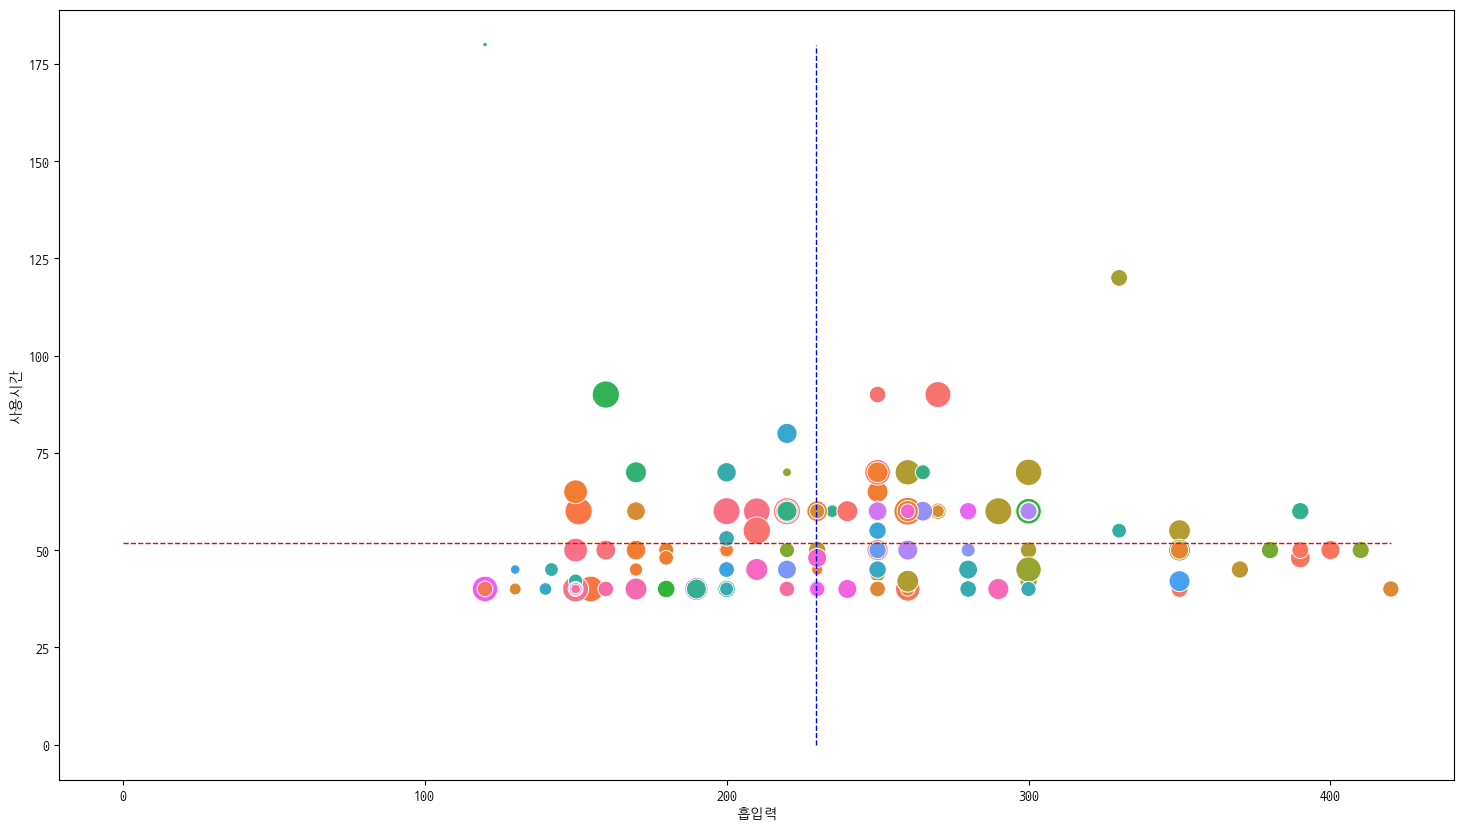

In [63]:
plt.figure(figsize=(18,10))
sns.scatterplot(x='흡입력',y='사용시간',data=chartData,size='가격',hue=chartData['회사명'],sizes=(10,400),legend=False)

plt.plot([0,suctionMax],[useTimeMean2,useTimeMean2],'r--',lw=1) # 사용시간 평균치에 선 긋기
plt.plot([suctionMean2,suctionMean2],[0,useTimeMax],'b--',lw=1) # 흡입력의 평균치에 선 긋기

plt.show()

In [64]:
## 인기제품 데이터 시각화
chartDataTop = chartData[:20]

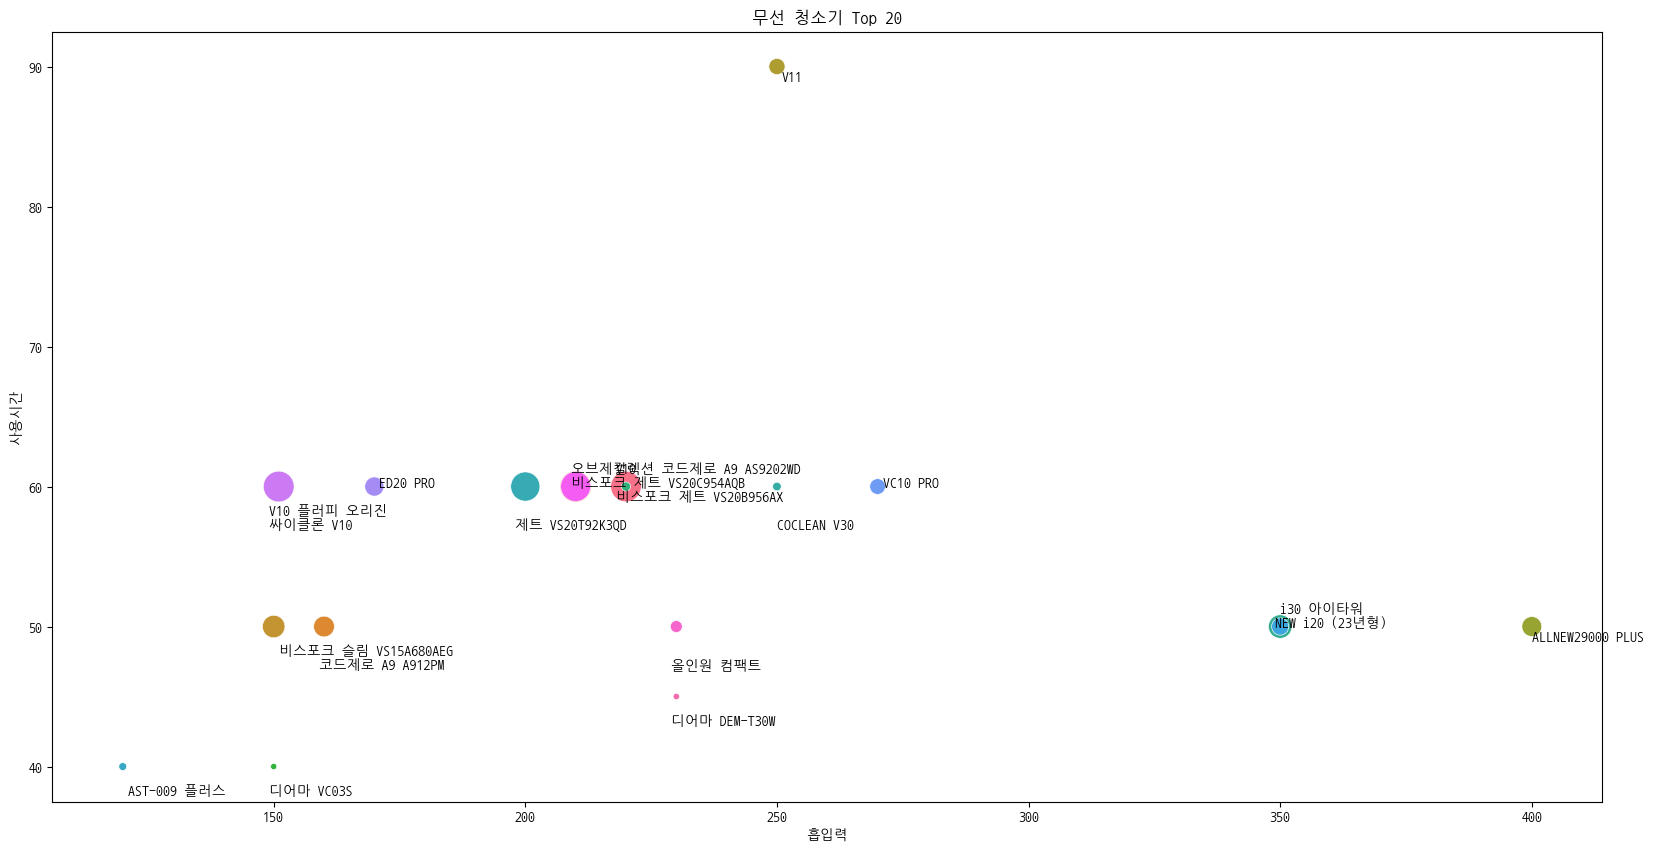

In [103]:
import random

fig = plt.figure(figsize=(20,10))
sns.scatterplot(data=chartDataTop,x='흡입력',y='사용시간',size='가격',sizes=(20,500),legend=False,hue=chartDataTop['모델명'])
plt.title('무선 청소기 Top 20')


for index, row in chartDataTop.iterrows():
    x = row['흡입력'] + random.randrange(-2,2)
    y = row['사용시간'] + random.randrange(-3,2)
    s = row['모델명']
    plt.text(x,y,s, size=10)

plt.show()

##### 결론
- 데이터분석을 위한 전처리는 쉽지 않으나 반드시 필요하다.
- 결과들이 예상이나, 실제와는 다를 수 있다.